In [1]:
%matplotlib inline 
from bs4 import BeautifulSoup
import urllib2
import requests
import pandas as pd
import re
import time
import numpy as np
import json
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import matplotlib.pyplot as plt
from pyquery import PyQuery as pq

In [2]:
with open("tempdata/polinfo.json") as json_file:
    pol_pages = json.load(json_file) # Next iterations will start from here!

### First we start with the income data for each candidate, collecting all info in a csv file. ###

In [3]:
cleaner = lambda e: int(re.findall('\d+', e.replace(',', '').split(" ~ ")[0])[0])
income_cols = ["Relation","PAN","Year","Income"]

def income_table(candidate_id):
    page_candidate = pol_pages[candidate_id]
    c_soup = BeautifulSoup(page_candidate,"html.parser")
    table_titles =[x.get_text().strip() for x in c_soup.findAll("h3")]
    tables = [x.find_next() for x in c_soup.findAll("h3")]
    dict_tab = dict(zip(table_titles,tables))
    income_tab = dict_tab['Details of PAN and status of Income Tax return']
    income_rows = income_tab.find_all("tr")
    dict_income = {}
    df_inc = pd.DataFrame([])
    if income_cols==[]:
        dict_income = {'HH':{"Year":np.nan,"PAN":"N","Relation":np.nan,"Income":np.nan}}
    else:
        for r in income_rows[1:]:
            list_items = [x.get_text() for x in r.findAll("td")]
            if len(list_items)==4 and list_items[3]!="Nil":
                list_items[3] = cleaner(list_items[3])
            if len(list_items)==4 and list_items[3]=="Nil":
                list_items[3] = 0
            dict_income[list_items[0]] = dict(zip(income_cols,list_items))
        df_inc = df_inc.from_dict(dict_income,orient = "index")
    try:
        df_inc = df_inc[df_inc.PAN=="Y"]
        HHinc = np.sum(df_inc['Income'])
        HHDeclarations = np.count_nonzero(df_inc['PAN'])
        self_income = dict_income['self']['Income']
        self_declare = dict_income['self']['PAN']
    except AttributeError:
        df_inc=df_inc
        HHinc = np.nan
        HHDeclarations = 0
        self_income = np.nan
        self_declare = np.nan
    newdict = {'self_inc':self_income,'self_declare':self_declare,'HHinc':HHinc,"HHDeclarations":HHDeclarations}
    return newdict

In [4]:
%%time
counterror = 0
dict_allinc = {}
for k,cid in enumerate(pol_pages.keys()):
    try:
        dict_allinc[cid] = income_table(cid)
    except TypeError:
        counterror = counterror+1
        print "Error with this page: ", cid
    if k%100==0:
        print k,
print "\n Number of errors: ", counterror

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 
 Number of errors:  0
Wall time: 7min 53s


In [5]:
d_inc_HH=pd.DataFrame([])
d_inc_HH = d_inc_HH.from_dict(dict_allinc,orient = "index") #d_inc_HH associates income to all candidates
                                                             # as well as for the whole family
                                                             # and the number of declarations
d_inc_HH.to_csv("C:\Users\mkkes_000\Dropbox\Indiastuff\OutputTables\incomes.csv", index=True)
d_inc_HH.head()

,HHinc,HHDeclarations,self_declare,self_inc
candidate.php?candidate_id=10,NaN,0,NaN,NaN
candidate.php?candidate_id=100,31990610,2,Y,26161550
candidate.php?candidate_id=1000,200000,1,Y,200000
candidate.php?candidate_id=1001,0,1,Y,0
candidate.php?candidate_id=1002,0,1,Y,0


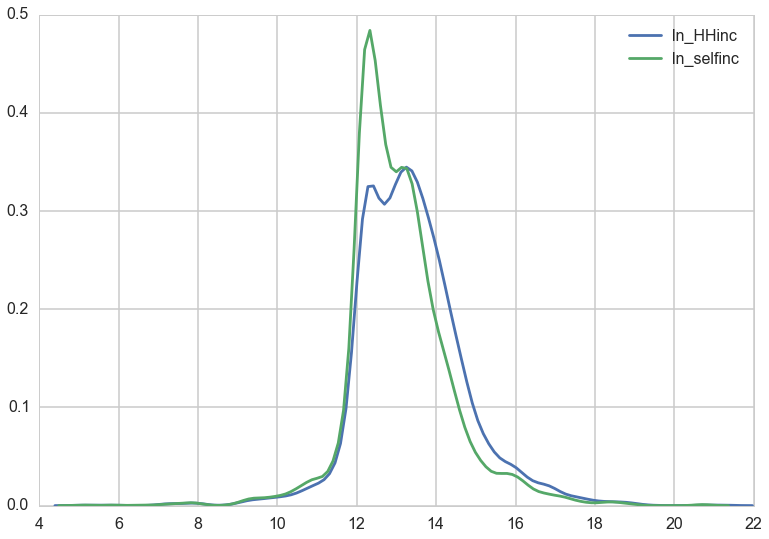

In [6]:
#This part is just to play a bit with incomes
d_inc = d_inc_HH.copy()
d_inc['ln_HHinc'] = np.log(d_inc['HHinc'])
d_inc['ln_selfinc'] = np.log(d_inc['self_inc'])
d_inc['sh_self'] = d_inc['self_inc']/d_inc['HHinc']
sns.kdeplot(d_inc.ln_HHinc)
sns.kdeplot(d_inc.ln_selfinc)

In [23]:
d_inc[d_inc.HHinc!=0].describe()

,HHinc,HHDeclarations,self_inc,ln_HHinc,ln_selfinc,sh_self
count,3.797000e+03,5965.000000,3.797000e+03,3797.000000,3797.000000,3797.000000
mean,2.907485e+06,1.146857,2.010333e+06,13.377243,-inf,0.754972
std,3.334908e+07,1.076341,2.396129e+07,1.336438,NaN,0.325898
min,1.670000e+02,0.000000,0.000000e+00,5.117994,-inf,0.000000
25%,2.609200e+05,0.000000,2.023000e+05,12.471969,12.217507,0.532683
50%,5.855120e+05,1.000000,3.750000e+05,13.280242,12.834681,0.991629
75%,1.295175e+06,2.000000,8.150000e+05,14.074156,13.610943,1.000000
max,1.684165e+09,6.000000,1.016221e+09,21.244536,20.739357,8.000000


### In this second part we look at the personal information for each candidate. ###

In [57]:
cols = ['cid','full_name','district','state','party_full','address','self_profession','spouse_profession','age']
def personal_info(candidate_id):
    page_candidate = pol_pages[candidate_id]
    c_soup = BeautifulSoup(page_candidate,"html.parser")
    personal = c_soup.findAll(attrs={"class": "grid_3 alpha"})[0]
    full_name = personal.find("h2").get_text().strip().title()
    district1 = personal.find("h5").get_text().strip()
    district = district1.title()
    state = district1[district1.find("(")+1:district1.find(")")].title()
    grid2 = personal.findAll(attrs={"class":"grid_2 alpha"})
    party_full = grid2[0].get_text().split(":")[1].split("\n")[0]
    age = grid2[2].get_text().split(":")[1].split("\n")[0]
    try:
        age = float(age)
    except ValueError:
        age = np.nan
    address = grid2[3].get_text().split(":")[1].split("\n")[1].strip() # Careful this one changes
    self_profession = personal.find("p").get_text().split('\n')[0].split(":")[1].capitalize()
    spouse_profession = personal.find("p").get_text().split('\n')[1].split(":")[1].capitalize()
    list_info = [candidate_id,full_name,district,state,party_full,address,self_profession,spouse_profession]
    list_encode = [x.encode('utf-8') for x in list_info]+[age]
    dict_info = dict(zip(cols,list_encode))
    return dict_info

In [58]:
personal_info(pol_pages.keys()[20])

{'address': 'Village Khachriya Chrawant Tehsil Malhargah Village Bhadhsor',
 'age': 57.0,
 'cid': 'candidate.php?candidate_id=4796',
 'district': 'Mandsour  (Madhya Pradesh)',
 'full_name': 'Banshilal Patidar',
 'party_full': 'Bahujan Sangharshh Dal',
 'self_profession': 'Agriculture ',
 'spouse_profession': 'House wife',
 'state': 'Madhya Pradesh'}

In [59]:
%%time
counterror = 0
dict_allcand = {}
for k,cid in enumerate(pol_pages.keys()):
    try:
        dict_allcand[cid] = personal_info(cid)
    except TypeError:
        counterror = counterror+1
        print "Error with this page: ", cid
    if k%100==0:
        print k,
print "Number of errors: ", counterror

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 Number of errors:  0
Wall time: 9min 16s


In [60]:
d_perso_info = pd.DataFrame([])
d_perso_info = d_perso_info.from_dict(dict_allcand, orient="index") # Dumping into a dataframe
d_perso_info.to_csv("C:\Users\mkkes_000\Dropbox\Indiastuff\OutputTables\info_perso_LS2014.csv",index = True)

In [61]:
d_perso_info.head(10)

,self_profession,party_full,district,cid,age,state,full_name,address,spouse_profession
candidate.php?candidate_id=10,Social worker,SUCI(C),Kottayam (Kerala),candidate.php?candidate_id=10,46,Kerala,N.K.Biju,"Naduvathuseril, Sachivothamapuramla, Kottayam",Social worker
candidate.php?candidate_id=100,Leader of opposition rajya sabha,BJP,Amritsar (Punjab),candidate.php?candidate_id=100,61,Punjab,Arun Jaitley,A-44 Kailash Colony New Delhi 110048,House wife
candidate.php?candidate_id=1000,Bussiness/self emplyed,IND,North East Delhi (National Capital Territory ...,candidate.php?candidate_id=1000,38,National Capital Territory Of Delhi,Amit Kumar Sharma,"506, CHANDER LOK MANDOLI ROAD SHAHDOR DELHI-93",Bussiness/ self employed
candidate.php?candidate_id=1001,Property dealer,JKNPP,North East Delhi (National Capital Territory ...,candidate.php?candidate_id=1001,33,National Capital Territory Of Delhi,Mohd Hasnan Khan,B1/498 GALI NO 4 V BLOK VIJAY PARK DELHI 53,
candidate.php?candidate_id=1002,Business,National Loktantrik Party,North East Delhi (National Capital Territory ...,candidate.php?candidate_id=1002,56,National Capital Territory Of Delhi,Roshan Ali,"A-544, 6 NO-15 SRI RAM COLONY RAJIV NAGAR DELH...",House wife
candidate.php?candidate_id=1003,Nothing,IND,North East Delhi (National Capital Territory ...,candidate.php?candidate_id=1003,78,National Capital Territory Of Delhi,H.K. Mahendru,"120, Pocket-D, Dislhad Garden Delhi",
candidate.php?candidate_id=1004,Self employee,AITC,North East Delhi (National Capital Territory ...,candidate.php?candidate_id=1004,26,National Capital Territory Of Delhi,Mohd Arif Siddique,"D-1/75, G.NO.-1, Nehru Vihar Mustfabad Delhi-94",
candidate.php?candidate_id=1005,Social worker and business,SHS,North East Delhi (National Capital Territory ...,candidate.php?candidate_id=1005,49,National Capital Territory Of Delhi,Om Dutt Sharma,"House No. 1/11820/1, Block- C, Opposite Parsur...",House wife
candidate.php?candidate_id=1006,Tuetor (teachy),Ambedkar National Congress,North East Delhi (National Capital Territory ...,candidate.php?candidate_id=1006,31,National Capital Territory Of Delhi,Pradesh Kumar,"10/375-B, Mandoli Extn. Delhi-93",Tuetor (teachy)
candidate.php?candidate_id=1008,Student,AITC,Kairana (Uttar Pradesh),candidate.php?candidate_id=1008,29,Uttar Pradesh,Diwakar,"Resident Of H.No. 1096, Shivpuri Hapur",House hold


In [62]:
d_perso_info.describe()

,age
count,8128.000000
mean,47.197219
std,11.929827
min,21.000000
25%,38.000000
50%,46.000000
75%,56.000000
max,93.000000


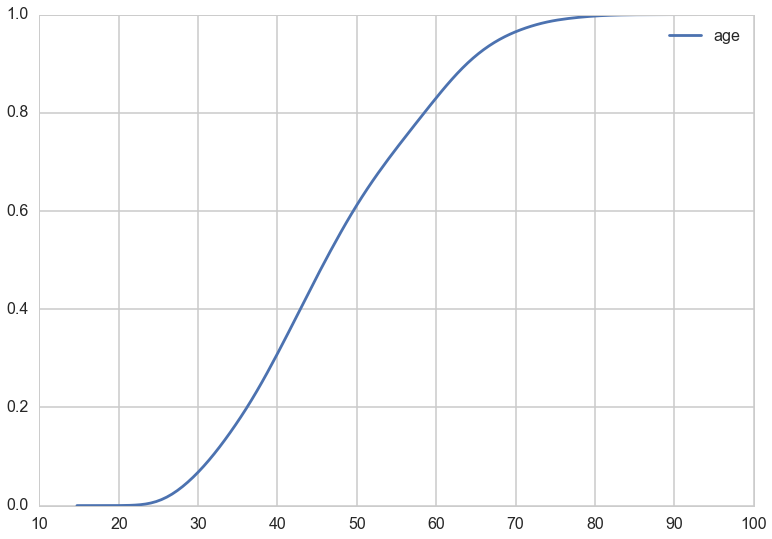

In [68]:
sns.kdeplot(d_perso_info.age.dropna(),cumulative=True)